In [1]:
import numpy as np;
import pandas as pd;
import math;
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, Model
import pprint as pp
from keras.layers import Conv2D, Dense, Dropout, Flatten,MaxPooling2D, Activation, Input, UpSampling2D

Using TensorFlow backend.


In [2]:
def reduceByVal(val, X):
    for letterIndex in range(0, X.shape[0] - 1):
        for row in range(0, X.shape[1] - 1):
            for col in range(0, X.shape[2] -1):
                X[letterIndex][row][col] =  X[letterIndex][row][col] /val
    return X

In [3]:
def shapeAndRemoveFeats(df, unwantedFeatures):
    Y = df["m_label"]
    Y = Y.to_numpy()
    rowCount = Y.size;
    X = df.drop(unwantedFeatures,axis = 1)
    X = X.to_numpy(np.float32)
    X = np.reshape(X, (rowCount, 20, 20))
    print(X.shape)
    return X,Y

In [4]:
def toNPArr(df, unwantedFeatures):
#     Y = df["m_label"]
#     Y = Y.to_numpy()
#     rowCount = Y.size;
#     X = df.drop(unwantedFeatures,axis = 1)
#     X = X.to_numpy(np.float32)
#     print(X.shape)
    X,Y = shapeAndRemoveFeats(df, unwantedFeatures)

#     X = np.reshape(X, (rowCount, 20, 20))
#     for letterIndex in range(0, X.shape[0] - 1):
#         for row in range(0, X.shape[1] - 1):
#             for col in range(0, X.shape[2] -1):
#                 X[letterIndex][row][col] =  X[letterIndex][row][col] /255.0
    X = reduceByVal(255.0, X)
    
    return X, Y

In [5]:
def expandLetter(X):
    for row in range(0, X.shape[0] - 1):
            for col in range(0, X.shape[1] -1):
                X[row][col] =  X[row][col] *255.0
    return X

In [6]:
def toCharMap(Y):
    uniqueChars = list((set(Y)))
#     uniqueChars = np.sort(np.asarray(uniqueChars))
    char_to_ix = { ch:i for i,ch in enumerate(uniqueChars) }
    ix_to_char = { i:ch for i,ch in enumerate(uniqueChars) }
    return char_to_ix, ix_to_char



In [7]:
def testShaping():
    print(X.shape);
    row = df.iloc[1]
    expected = list(row[12:33]);
    recieved = list(X[1][0]);
    for i in range(0,19):
        print(expected[i], ":", recieved[i])

In [8]:
def createInitialModel(outputLayerSize):
    model = Sequential()
    model.add(Conv2D(64,kernel_size=3, activation='relu', input_shape=(20,20,1)))
    model.add(MaxPooling2D((2,2), padding = "same"))
    model.add(Conv2D(32,kernel_size=3, activation='relu'))
    model.add(MaxPooling2D((2,2), padding = "same"))
    model.add(Flatten())
    model.add(Dropout(.1))
    model.add(Dense(1000, activation='relu')) 
    model.add(Dense(outputLayerSize, activation='softmax'))
    return model

In [9]:
def createCrystalBall(outputSize):
    crystalBall = Sequential()
    crystalBall.add(Conv2D(200,kernel_size=5, activation='relu', input_shape=(20,20,1)))
    crystalBall.add(MaxPooling2D((1,1), padding = "same"))
    crystalBall.add(Conv2D(100,kernel_size=5, activation='relu'))
#     crystalBall.add(Dropout(.2))
    crystalBall.add(Conv2D(64,kernel_size=5, activation='relu'))
#     crystalBall.add(MaxPooling2D((2,2), padding = "same"))
    crystalBall.add(Flatten())
    crystalBall.add(Dropout(.2))
    crystalBall.add(Dense(1000, activation='relu'))
    crystalBall.add(Dense(outputSize, activation='softmax'))
    return crystalBall



In [10]:
def maxIndex(vals):
    index = np.where(vals == np.amax(vals))
    return index;

In [11]:
def findIncorrectClassifications(predicted_index, y_test_onehot):
    incorrect_indexes = []
    expected_index = []
    result_index = []
    incorrect_count = 0;
    for i in range(0, len(predicted_index)):
        expected = maxIndex(y_test_onehot[i]);
        result = maxIndex(predicted_index[i]);
        if  expected != result:
            incorrect_count += 1;
            incorrect_indexes.append(i)
            expected_index.append(int(expected[0]));
            result_index.append(int(result[0]));
    #         print("expected = ", expected, "result = ", result)

    print("incorrect_count:", incorrect_count)
    print("accuracy~:", (len(predicted_index) - incorrect_count)/len(predicted_index))
    return incorrect_indexes, expected_index, result_index

In [12]:
def getIncorrectLetters(ix_to_char, expected_index, result_index, incorrect, X_test):
    incorrect_letters = []
    incorrect_count = len(incorrect)
    
    expected_char = [ix_to_char[ix] for ix in expected_index]
    received_char = [ix_to_char[ix] for ix in result_index]
    for i in np.arange(incorrect_count):
        incorrect_letters.append(expandLetter(X_test[incorrect[i]].reshape(20,20)))
    return incorrect_letters, expected_char,received_char

In [13]:
def drawLetters(figH, letters, showCharComparison, expected_char=[], received_char=[]):
    letters_count = len(letters)
    plt.figure(figsize= (18, figH))
    for i in np.arange(letters_count):
        plt.subplot(math.ceil(letters_count/5) ,5,i+1)
        plt.subplots_adjust(hspace = 0.75)
        if(showCharComparison):
            ax = plt.gca()
            ax.set_title('exp:' + str(expected_char[i]) + " rec" + str(received_char[i]))
        plt.imshow(letters[i], cmap= 'Greys', interpolation = 'none')

In [14]:
def drawIncorrectLetters(ix_to_char, expected_index, result_index, incorrect, X_test, figH = 20):
#     incorrect_letters = []
#     incorrect_count = len(incorrect)
    
#     expected_char = [ix_to_char[ix] for ix in expected_index]
#     received_char = [ix_to_char[ix] for ix in result_index]
#     for i in np.arange(incorrect_count):
#         incorrect_letters.append(expandLetter(X_test[incorrect[i]].reshape(20,20)))
    incorrect_letters, expected_char,received_char = getIncorrectLetters(ix_to_char, expected_index, result_index, incorrect, X_test)

#     plt.figure(figsize= (18, figH))
#     for i in np.arange(incorrect_count):
#         plt.subplot(math.ceil(incorrect_count/5) ,5,i+1)
#         plt.subplots_adjust(hspace = 0.75)
#         ax = plt.gca()
#         ax.set_title('exp:' + str(expected_char[i]) + " rec" + str(received_char[i]))
#         plt.imshow(incorrect_letters[i], cmap= 'Greys', interpolation = 'none')
    drawLetters(figH, incorrect_letters, True, expected_char, received_char)
    return

## Part 1: Data acquisition and cleanup

In [15]:
df = pd.read_csv("./fontFiles/HARLOW.csv")
X, Y = toNPArr(df, ['font', 'fontVariant', 'm_label', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'])

(952, 20, 20)


In [16]:
# print(sorted(Y, reverse=True))
unique = Counter(Y)
print(len(unique))

238


## Part 2/ Part 3


In [17]:
char_to_ix,ix_to_char = toCharMap(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1, test_size=0.25)

train_Y_counts = Counter(Y_train)
test_Y_counts = Counter(Y_test)

x_test_unshaped = X_test
X_train = X_train.reshape(-1,20,20,1)
X_test = X_test.reshape(-1,20,20,1)
print("unique in training: ",len(train_Y_counts))
print("unique in test: ",len(test_Y_counts))
print(X_train.shape)

unique in training:  237
unique in test:  166
(714, 20, 20, 1)


In [18]:
Y_train_ix = [char_to_ix[c] for c in Y_train]
Y_test_ix = [char_to_ix[c] for c in Y_test]

y_train_onehot = to_categorical(Y_train_ix)
y_test_onehot = to_categorical(Y_test_ix)


In [19]:

model = createInitialModel(len(char_to_ix))

W0721 11:53:31.915710 4690458048 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 11:53:31.930317 4690458048 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 11:53:31.932782 4690458048 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0721 11:53:31.951109 4690458048 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0721 11:53:31.990005 4690458048 deprecation_wrapper.py:119] From /usr/loca

## Part 4: 

### fitting the initial model

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train_onehot, validation_data=(X_test, y_test_onehot), epochs=20)

W0721 11:53:32.065483 4690458048 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0721 11:53:32.097457 4690458048 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0721 11:53:32.204815 4690458048 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 714 samples, validate on 238 samples
Epoch 1/20
714/714 [==============================] - 1s 1ms/step - loss: 6.1237 - acc: 0.0462 - val_loss: 5.0206 - val_acc: 0.1050
Epoch 2/20
714/714 [==============================] - 0s 630us/step - loss: 3.3517 - acc: 0.2871 - val_loss: 2.7657 - val_acc: 0.3319
Epoch 3/20
714/714 [==============================] - 0s 648us/step - loss: 1.6623 - acc: 0.4902 - val_loss: 1.8306 - val_acc: 0.5252
Epoch 4/20
714/714 [==============================] - 0s 599us/step - loss: 1.3104 - acc: 0.6317 - val_loss: 1.3603 - val_acc: 0.6050
Epoch 5/20
714/714 [==============================] - 0s 625us/step - loss: 0.8446 - acc: 0.7409 - val_loss: 1.2558 - val_acc: 0.6639
Epoch 6/20
714/714 [==============================] - 0s 589us/step - loss: 0.7413 - acc: 0.8011 - val_loss: 1.2641 - val_acc: 0.6933
Epoch 7/20
714/714 [==============================] - 0s 593us/step - loss: 0.6034 - acc: 0.8179 - val_loss: 1.0379 - val_acc: 0.7563
Epoch 8/20
714/714

incorrect_count: 35
accuracy~: 0.8529411764705882


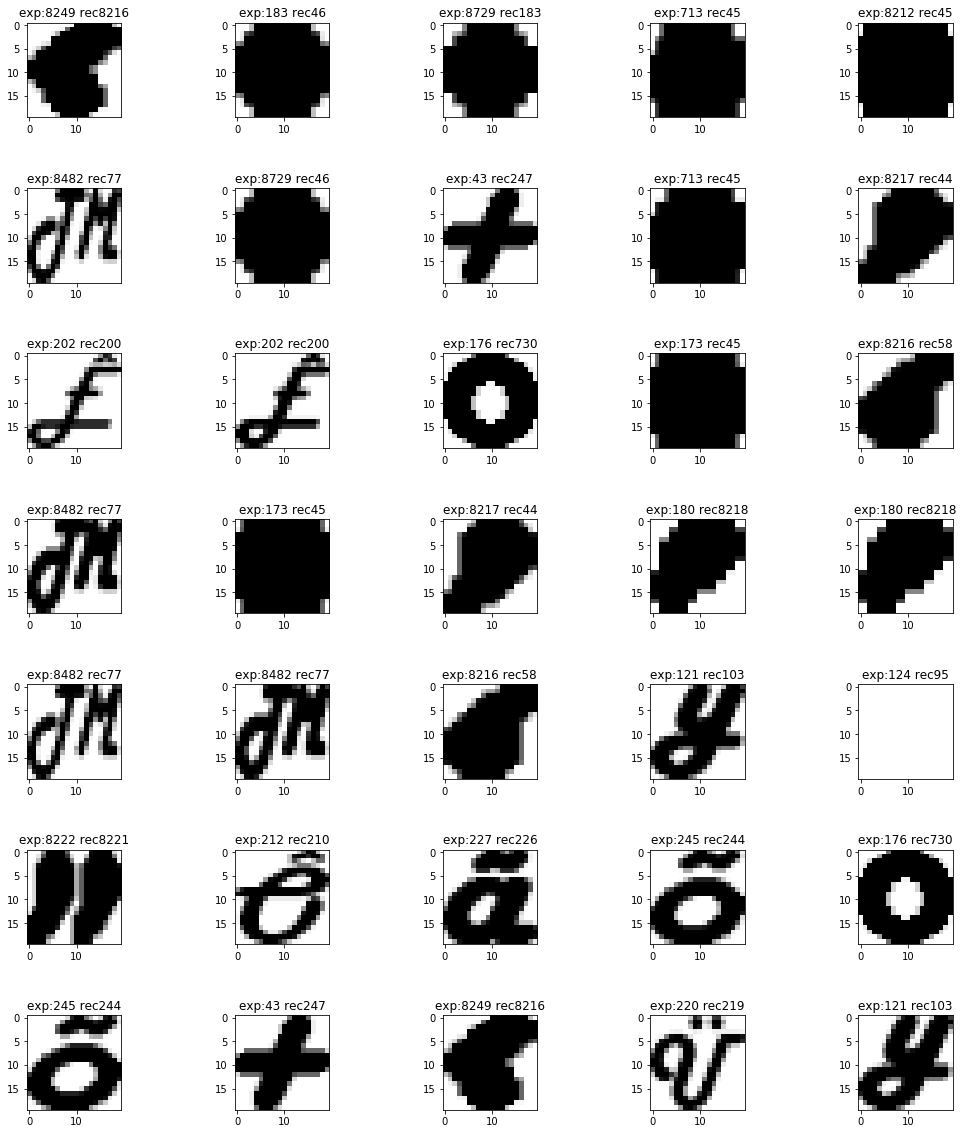

In [21]:
predicted_index = model.predict(X_test)

incorrect_indexes, expected_index, result_index = findIncorrectClassifications(predicted_index, y_test_onehot)
drawIncorrectLetters(ix_to_char, expected_index, result_index, incorrect_indexes, X_test)

The inital dataset had a training accuracy of 92% and a testing accuracy of 80%;

In [22]:
crystal_ball_har = createCrystalBall(len(char_to_ix))
crystal_ball_har.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
crystal_ball_har.fit(X_train, y_train_onehot, validation_data=(X_test, y_test_onehot), epochs=20, batch_size =75)

Train on 714 samples, validate on 238 samples
Epoch 1/20
714/714 [==============================] - 5s 7ms/step - loss: 5.4553 - acc: 0.0280 - val_loss: 6.5959 - val_acc: 0.0378
Epoch 2/20
714/714 [==============================] - 4s 6ms/step - loss: 3.6627 - acc: 0.2297 - val_loss: 4.8560 - val_acc: 0.2773
Epoch 3/20
714/714 [==============================] - 5s 7ms/step - loss: 2.0056 - acc: 0.4986 - val_loss: 3.9062 - val_acc: 0.4202
Epoch 4/20
714/714 [==============================] - 5s 7ms/step - loss: 1.3393 - acc: 0.6345 - val_loss: 2.9206 - val_acc: 0.6891
Epoch 5/20
714/714 [==============================] - 5s 7ms/step - loss: 0.9464 - acc: 0.7451 - val_loss: 3.0080 - val_acc: 0.6849
Epoch 6/20
714/714 [==============================] - 5s 7ms/step - loss: 0.7856 - acc: 0.7731 - val_loss: 2.8724 - val_acc: 0.7227
Epoch 7/20
714/714 [==============================] - 4s 6ms/step - loss: 0.6845 - acc: 0.8151 - val_loss: 2.8303 - val_acc: 0.7185
Epoch 8/20
714/714 [==========

#### note: new dataset txt loaded

In [23]:
df2 = pd.read_csv("./fontFiles/TXT.csv")
X2, Y2 = toNPArr(df2, ['font', 'fontVariant', 'm_label', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'])

(1308, 20, 20)


In [24]:
char_to_ix2,ix_to_char2 = toCharMap(Y2)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, random_state=1, test_size=0.2)

X_train2 = X_train2.reshape(-1,20,20,1)
X_test2 = X_test2.reshape(-1,20,20,1)

Y_train_ix2 = [char_to_ix2[c] for c in Y_train2]
Y_test_ix2 = [char_to_ix2[c] for c in Y_test2]

y_train_onehot2 = to_categorical(Y_train_ix2)
y_test_onehot2 = to_categorical(Y_test_ix2)

initialModelTxt = createInitialModel(len(char_to_ix2))

initialModelTxt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
initialModelTxt.fit(X_train2, y_train_onehot2, validation_data=(X_test2, y_test_onehot2), epochs=20)

Train on 1046 samples, validate on 262 samples
Epoch 1/20
1046/1046 [==============================] - 1s 1ms/step - loss: 6.2365 - acc: 0.0048 - val_loss: 5.7596 - val_acc: 0.0115
Epoch 2/20
1046/1046 [==============================] - 1s 707us/step - loss: 5.0479 - acc: 0.0602 - val_loss: 5.3675 - val_acc: 0.0229
Epoch 3/20
1046/1046 [==============================] - 1s 643us/step - loss: 3.5097 - acc: 0.2027 - val_loss: 4.3019 - val_acc: 0.1298
Epoch 4/20
1046/1046 [==============================] - 1s 691us/step - loss: 2.3926 - acc: 0.3824 - val_loss: 3.6750 - val_acc: 0.2328
Epoch 5/20
1046/1046 [==============================] - 1s 647us/step - loss: 1.8183 - acc: 0.5163 - val_loss: 3.2014 - val_acc: 0.3397
Epoch 6/20
1046/1046 [==============================] - 1s 726us/step - loss: 1.3670 - acc: 0.6166 - val_loss: 3.0448 - val_acc: 0.3626
Epoch 7/20
1046/1046 [==============================] - 1s 660us/step - loss: 1.1940 - acc: 0.6606 - val_loss: 2.6950 - val_acc: 0.4160
Epo

In [25]:
expected_ix_txt = initialModelTxt.predict(X_test2)
incorrect_ix_txt, expected_ix_txt, result_ix_txt = findIncorrectClassifications(expected_ix_txt, y_test_onehot2)

pp.pprint(expected_ix_txt)

incorrect_count: 137
accuracy~: 0.4770992366412214
[220,
 268,
 139,
 48,
 251,
 7,
 263,
 253,
 106,
 251,
 288,
 230,
 252,
 148,
 279,
 237,
 284,
 152,
 44,
 308,
 234,
 136,
 263,
 243,
 293,
 237,
 325,
 316,
 232,
 196,
 30,
 31,
 269,
 297,
 120,
 164,
 206,
 323,
 171,
 268,
 240,
 65,
 175,
 214,
 30,
 0,
 152,
 234,
 263,
 33,
 288,
 136,
 143,
 54,
 136,
 153,
 228,
 95,
 140,
 179,
 281,
 167,
 23,
 43,
 308,
 188,
 76,
 249,
 295,
 254,
 1,
 109,
 213,
 325,
 271,
 203,
 320,
 24,
 72,
 3,
 253,
 189,
 158,
 77,
 273,
 174,
 313,
 289,
 136,
 76,
 43,
 148,
 165,
 214,
 183,
 293,
 197,
 3,
 316,
 251,
 278,
 123,
 168,
 31,
 243,
 84,
 145,
 270,
 309,
 268,
 32,
 181,
 262,
 297,
 174,
 260,
 1,
 168,
 181,
 132,
 48,
 140,
 114,
 186,
 33,
 118,
 177,
 66,
 86,
 215,
 205,
 301,
 125,
 220,
 254,
 250,
 165]


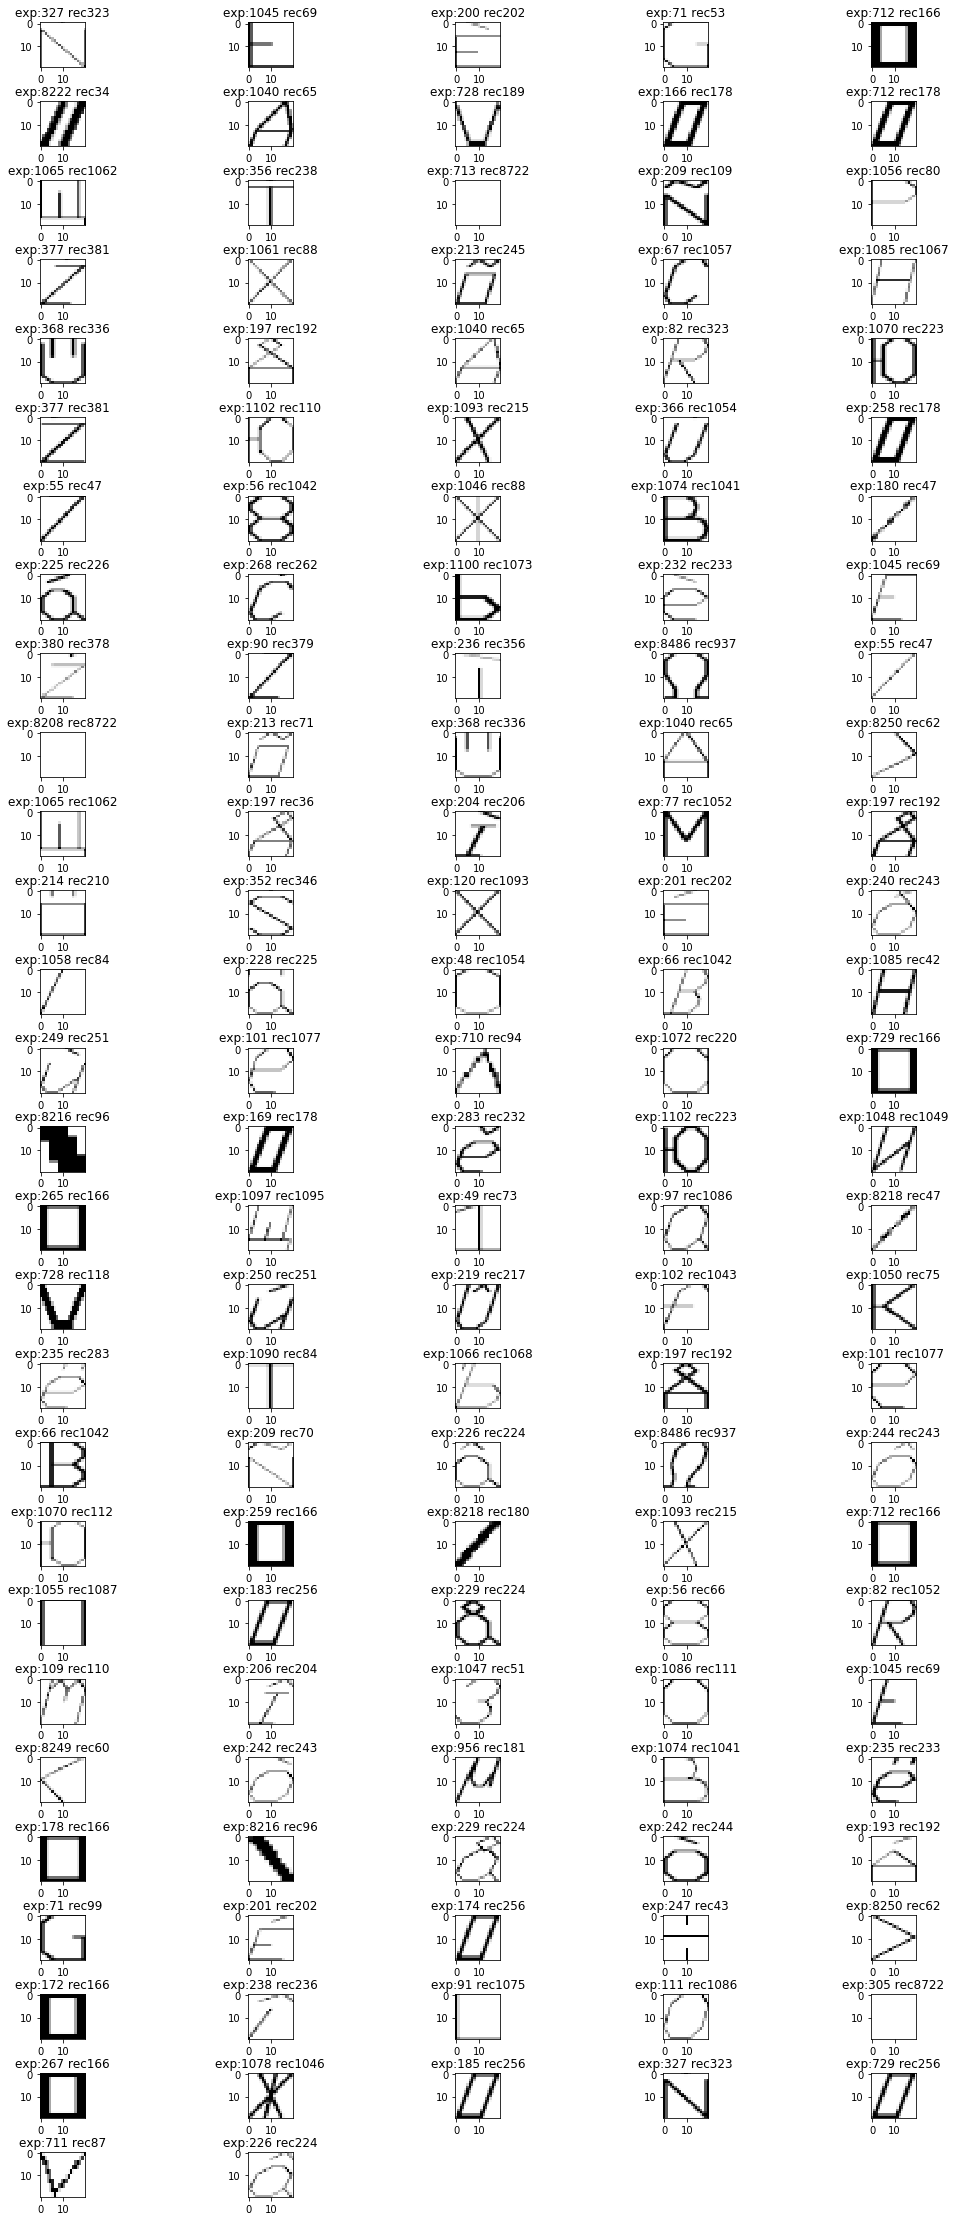

In [26]:
drawIncorrectLetters(ix_to_char2, expected_ix_txt, result_ix_txt, incorrect_ix_txt, X_test2, 40)

In [27]:
crystal_ball_txt_model = createCrystalBall(len(char_to_ix2))
crystal_ball_txt_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
crystal_ball_txt_model.fit(X_train2, y_train_onehot2, validation_data=(X_test2, y_test_onehot2), epochs=20)

Train on 1046 samples, validate on 262 samples
Epoch 1/20
1046/1046 [==============================] - 8s 8ms/step - loss: 5.8308 - acc: 0.0067 - val_loss: 10.8809 - val_acc: 0.0076
Epoch 2/20
1046/1046 [==============================] - 7s 7ms/step - loss: 4.9592 - acc: 0.0621 - val_loss: 10.5559 - val_acc: 0.0305
Epoch 3/20
1046/1046 [==============================] - 8s 7ms/step - loss: 3.2691 - acc: 0.2266 - val_loss: 9.5909 - val_acc: 0.1641
Epoch 4/20
1046/1046 [==============================] - 7s 7ms/step - loss: 2.1763 - acc: 0.4321 - val_loss: 8.9074 - val_acc: 0.2634
Epoch 5/20
1046/1046 [==============================] - 7s 7ms/step - loss: 1.6319 - acc: 0.5497 - val_loss: 8.6073 - val_acc: 0.3359
Epoch 6/20
1046/1046 [==============================] - 7s 7ms/step - loss: 1.3506 - acc: 0.6071 - val_loss: 8.0642 - val_acc: 0.3779
Epoch 7/20
1046/1046 [==============================] - 8s 8ms/step - loss: 1.2457 - acc: 0.6138 - val_loss: 8.4429 - val_acc: 0.3855
Epoch 8/20
10

### Analysis of newtwork topology

As discussed with Ben, I tried several different network topologies to try and improve my network. Not many of the techniques that I tried were very effective. One consistency I noticed between all of the data is that all of the network topologies I tried seem to result in some degree of overfitting. To try and address the overfitting, I increased the size of the dropout layer from 5% to 20%. This didn't really seem to help much. The next thing I did was to increase the batch size from the standard 32 to 100. In some combination of network topologies, this approach seemed to help but results differred each time I trained the model making it difficult to conclusively say it was a better model. Lastly, to address overfitting, I adjusted the train/test split on the dataset. This had the biggest impact on the accuracy of the model. As seen in the example on the digit classifer, I originally had my training data set to 90% of the total dataset. I slowly bumped that up  in increments of 10% and found that the best results were at about 30%. This resulted in about a 3% increase in accuracy. To improve accuracy, I also tried changing the type of activation function from relu to sigmoid and other activation functions. This resulted in a dramatic decline to the accuracy of the model so I reverted to the previous design. Additionally, I tried to change the convolution layers by making the number of filters higher and played with the size of the filter, results seemed to be somewhat negligible. I tried adding an additional dense layer, which slowed down the training dramatically but didn't result in better accuracy. I added more convolution layers which also didn't help much. I increased the epoc size ( toward the beginning of my anaysis, it was originally 3) and that dramatically improved results up to about 20 epocs and after thata additional epocs didn't seem much improvement in accuracy. To better make sense of what characters I was misclassifying I decided to graph and anaylze which characters the model was getting wrong. The visualization revealed that mostly just oddly shaped characters where giving the model trouble.  

#### note: add a 3rd data split to create a joint dataset<br>
_m = merged


In [28]:
df3 = pd.read_csv("./fontFiles/RAGE.csv")
X, Y = toNPArr(df2, ['font', 'fontVariant', 'm_label', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'])
X_m = np.concatenate((X, X2),0)
Y_m = np.concatenate((Y, Y2),0)

char_to_ix_m ,ix_to_char_m = toCharMap(Y_m)

X_train_m, X_test_m, Y_train_m, Y_test_m = train_test_split(X_m, Y_m, random_state=1, test_size=0.2)

X_train_m = X_train_m.reshape(-1,20,20,1)
X_test_m = X_test_m.reshape(-1,20,20,1)

Y_train_ix_m = [char_to_ix_m[c] for c in Y_train_m]
Y_test_ix_m = [char_to_ix_m[c] for c in Y_test_m]

y_train_onehot_m = to_categorical(Y_train_ix_m)
y_test_onehot_m = to_categorical(Y_test_ix_m)

mergedModel= createInitialModel(len(char_to_ix_m))

mergedModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mergedModel.fit(X_train_m, y_train_onehot_m, validation_data=(X_test_m, y_test_onehot_m), epochs=20)

(1308, 20, 20)
Train on 2092 samples, validate on 524 samples
Epoch 1/20
2092/2092 [==============================] - 2s 905us/step - loss: 5.5352 - acc: 0.0406 - val_loss: 4.0627 - val_acc: 0.1393
Epoch 2/20
2092/2092 [==============================] - 1s 645us/step - loss: 2.7716 - acc: 0.3188 - val_loss: 2.4460 - val_acc: 0.3511
Epoch 3/20
2092/2092 [==============================] - 1s 644us/step - loss: 1.6544 - acc: 0.5335 - val_loss: 1.6982 - val_acc: 0.5229
Epoch 4/20
2092/2092 [==============================] - 1s 650us/step - loss: 1.2178 - acc: 0.6491 - val_loss: 1.4188 - val_acc: 0.6069
Epoch 5/20
2092/2092 [==============================] - 1s 640us/step - loss: 1.0044 - acc: 0.7141 - val_loss: 1.2358 - val_acc: 0.6469
Epoch 6/20
2092/2092 [==============================] - 1s 686us/step - loss: 0.9278 - acc: 0.7118 - val_loss: 1.1174 - val_acc: 0.6546
Epoch 7/20
2092/2092 [==============================] - 1s 644us/step - loss: 0.8073 - acc: 0.7438 - val_loss: 1.1445 - va

In [29]:
expected_ix_m = mergedModel.predict(X_test_m)
incorrect_ix_m, expected_ix_m, result_ix_m = findIncorrectClassifications(expected_ix_m, y_test_onehot_m)

incorrect_count: 141
accuracy~: 0.7309160305343512


### attempt to predict on a model we didn't train on:

In [116]:
invalid_ix = model.predict(X_test_m)
invalid, invalid_expected, invalid_result = findIncorrectClassifications(invalid_ix, y_test_onehot_m)

incorrect_count: 519
accuracy~: 0.009541984732824428


(952, 20, 20)
(976, 20, 20)


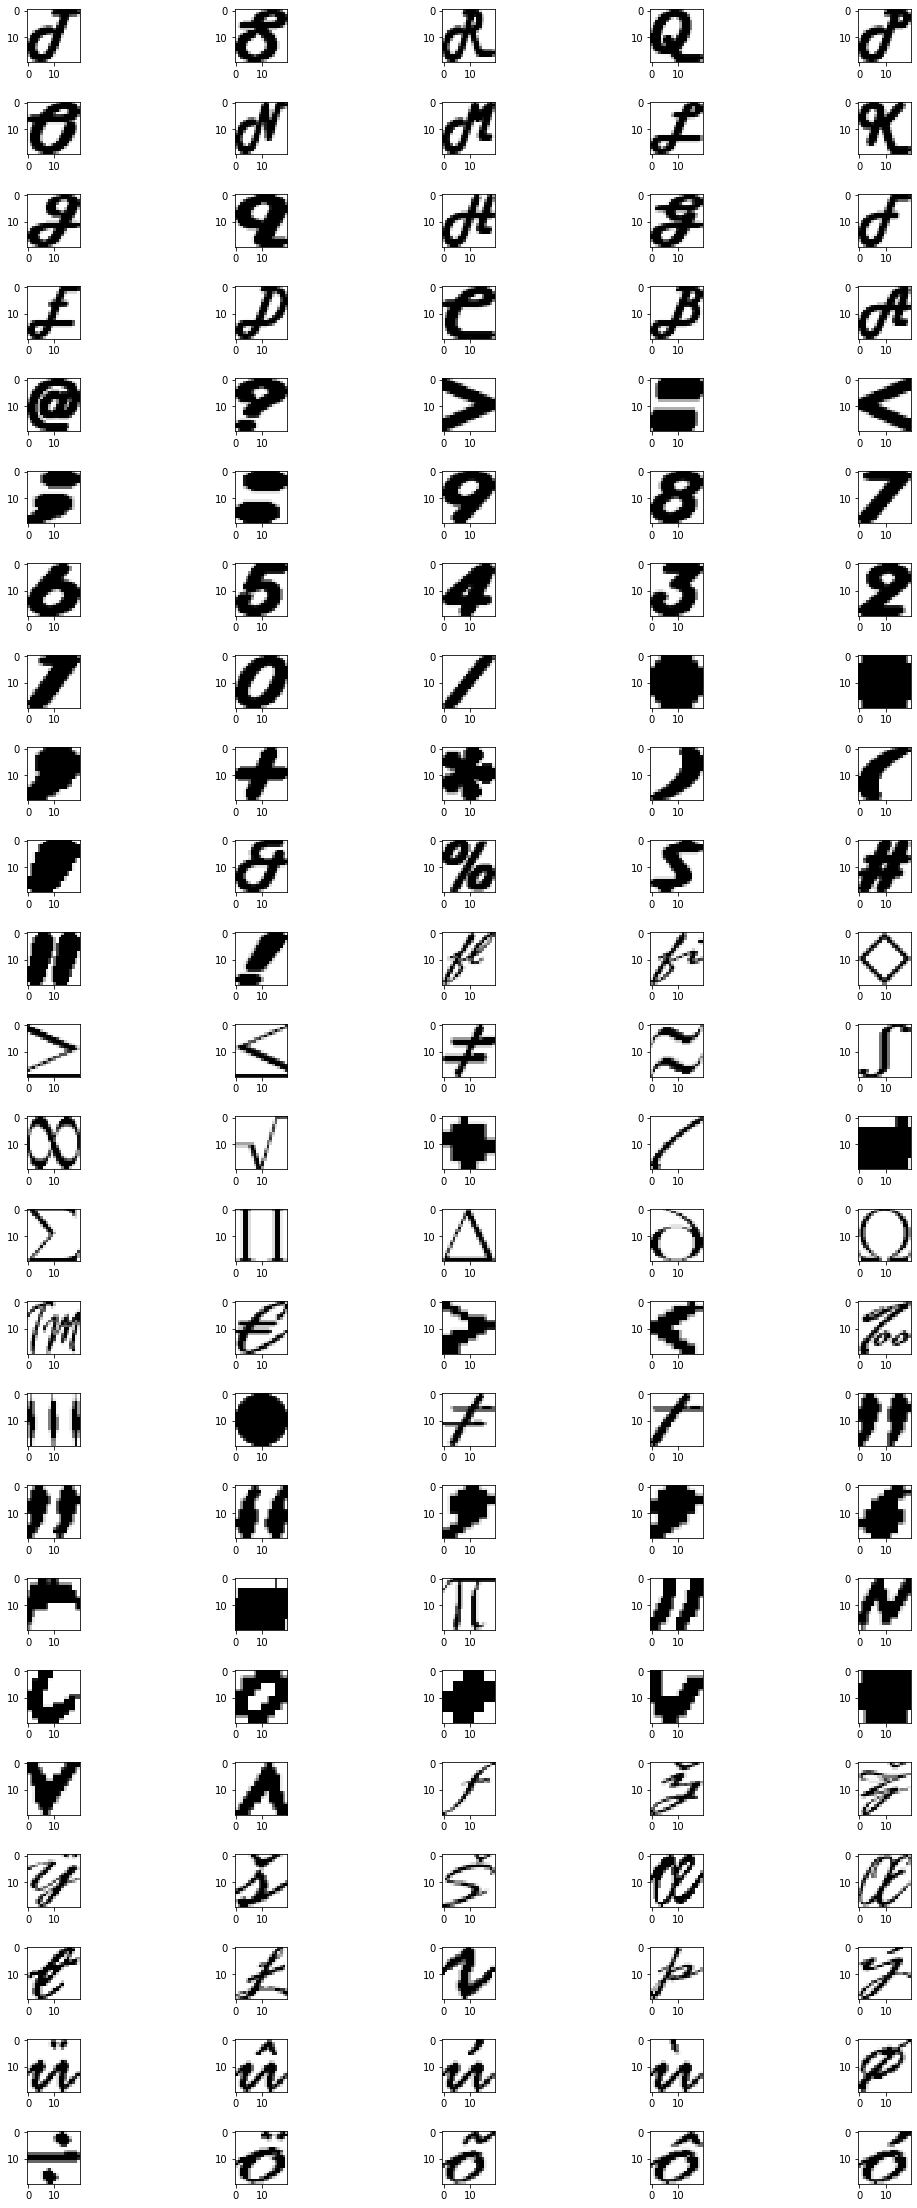

In [30]:
# to test concat works as expected
X, Y = shapeAndRemoveFeats(df, ['font', 'fontVariant', 'm_label', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'])
X2, Y2 = shapeAndRemoveFeats(df3, ['font', 'fontVariant', 'm_label', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'])
X_m = np.concatenate((X, X2),0)
Y_m = np.concatenate((Y, Y2),0)
drawLetters(40, X_m[900:1020],False)

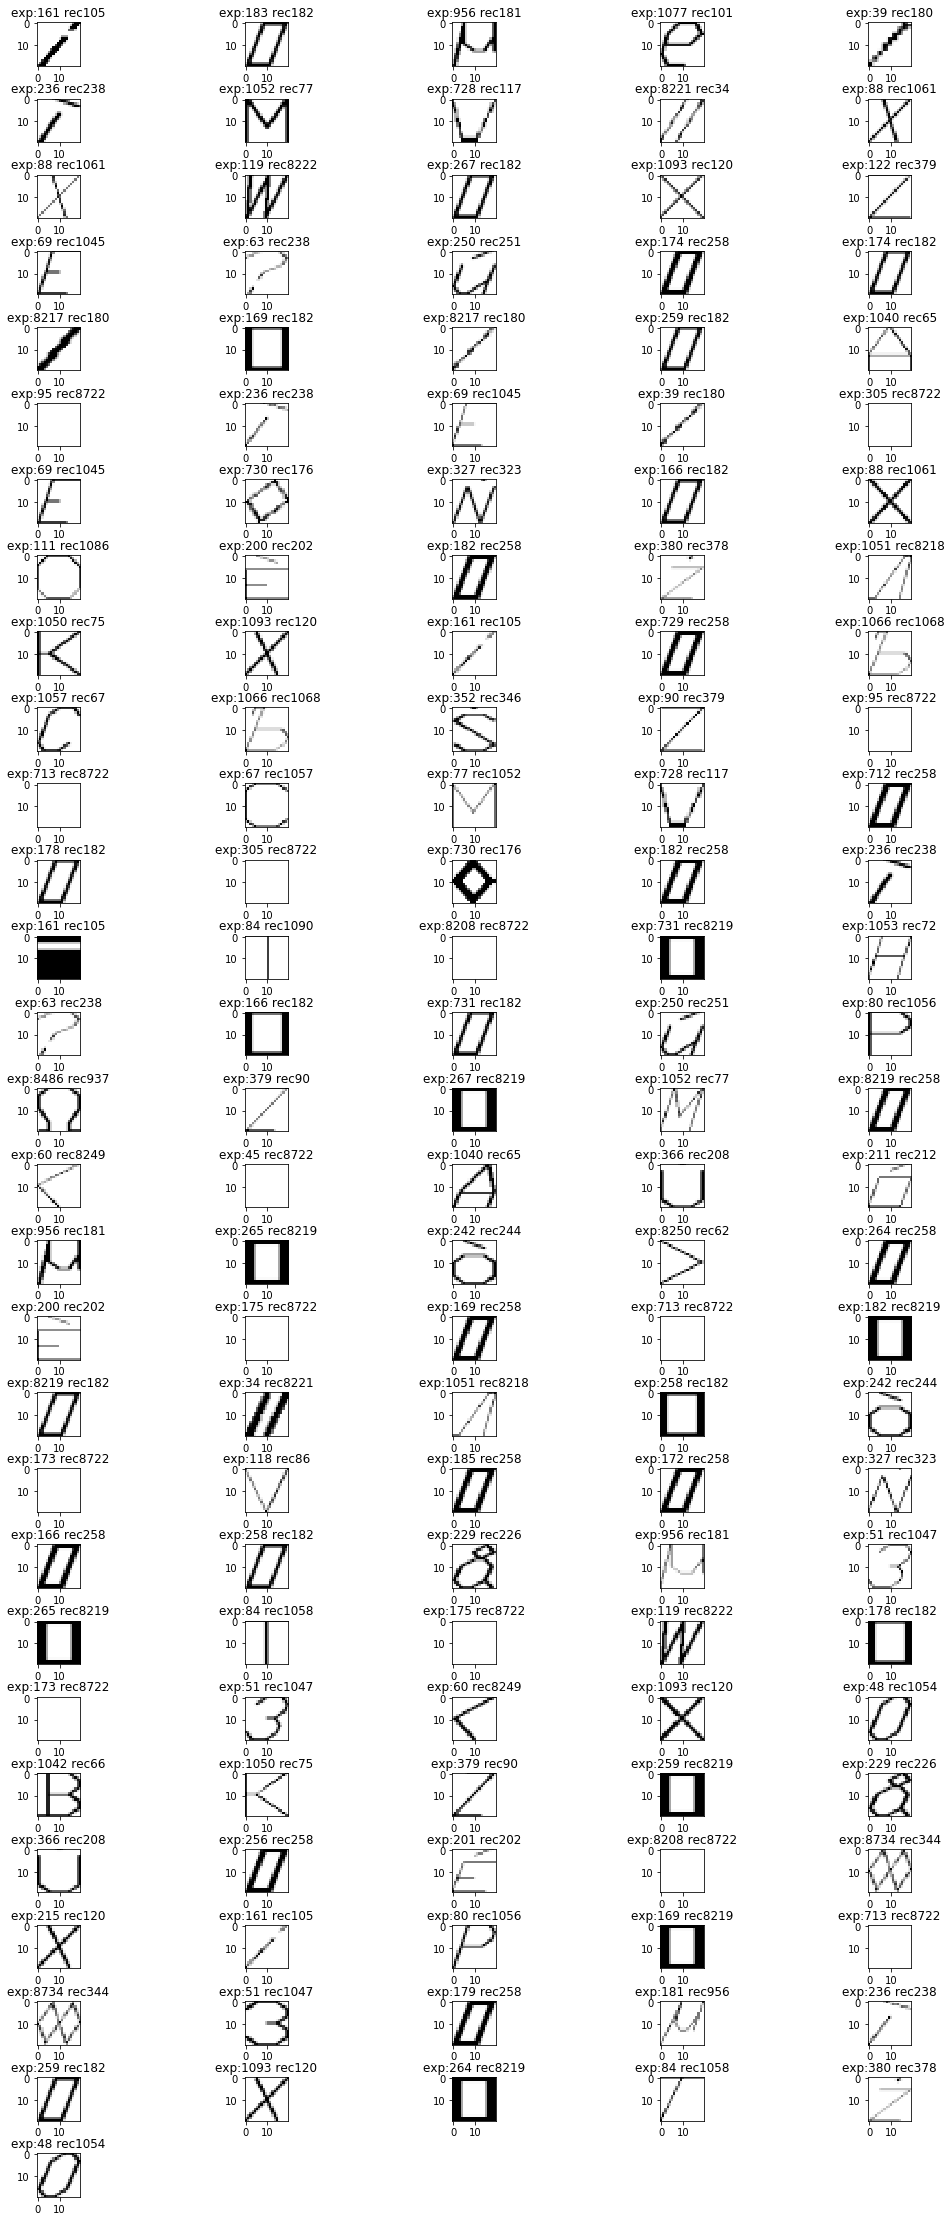

In [31]:
drawIncorrectLetters(ix_to_char_m, expected_ix_m, result_ix_m, incorrect_ix_m, X_test_m, 40)

The accuracy drops ~10% when training two different datasets together. 
The model seems to screw up on many of the same values as when tested independently. I also joined the arrays together, more of the incorrect come from the 2nd dataset. Trained on 1st dataset first?

TODO: make fuction to find most unsure letters. Draw those.

TODO: start autoencoders


When training on two different fonts the accuracy of the model goes down by about 10%. This makes intative sense because there is a little more variation in the data. It would be interesting to find out whether it could eventually overcome the additional error if you trained the model enough. When I tried to test on inputs I didn't train I got an accuracy of about 1.5%.This would make sense as the data would appear completely different to the model. 

### Part 5: Autoencoder

In [32]:
### font + noise
from keras.callbacks import TensorBoard

In [33]:
# df = pd.read_csv("./fontFiles/HARLOW.csv")
# X, Y = toNPArr(df, ['font', 'fontVariant', 'm_label', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'])

In [98]:
# df = pd.read_csv("./fontFiles/HARLOW.csv")
X, Y = toNPArr(df, ['font', 'fontVariant', 'm_label', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'])
char_to_ix,ix_to_char = toCharMap(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1, test_size=0.25)

X_train = X_train.reshape(-1,20,20,1)
X_test = X_test.reshape(-1,20,20,1)
Y_train_ix = [char_to_ix[c] for c in Y_train]
Y_test_ix = [char_to_ix[c] for c in Y_test]

y_train_onehot = to_categorical(Y_train_ix)
y_test_onehot = to_categorical(Y_test_ix)

(952, 20, 20)


In [99]:

noise_factor = 0.3
x_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
x_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

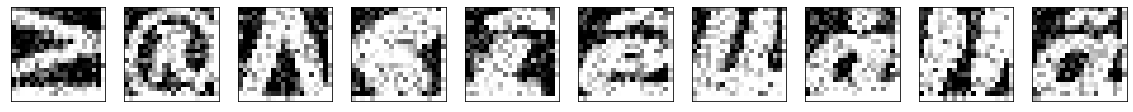

In [100]:

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(20, 20))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [110]:
input_img = Input(shape=(20, 20, 1))
x = Conv2D(32, (2, 2), activation='relu', padding='same')(input_img)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
denoiser_encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (2, 2), activation='relu', padding='same')(denoiser_encoded)
x = UpSampling2D((2, 2))(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
denoiser_decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

denoiser = Model(input_img, denoiser_decoded)
denoiser.compile(optimizer='adadelta', loss='binary_crossentropy')

In [111]:
denoiser.fit(x_train_noisy, X_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, X_test),
                callbacks=[TensorBoard(log_dir='/tmp/denoiser', histogram_freq=0, write_graph=False)])

Train on 714 samples, validate on 238 samples
Epoch 1/50
714/714 [==============================] - 1s 2ms/step - loss: 0.4713 - val_loss: -214298.4925
Epoch 2/50
714/714 [==============================] - 0s 628us/step - loss: -5.7254 - val_loss: -1303428.1477
Epoch 3/50
714/714 [==============================] - 0s 667us/step - loss: -55.3089 - val_loss: -6027644.3164
Epoch 4/50
714/714 [==============================] - 0s 668us/step - loss: -128.5257 - val_loss: -6027479.4620
Epoch 5/50
714/714 [==============================] - 1s 725us/step - loss: -128.9623 - val_loss: -6022126.3208
Epoch 6/50
714/714 [==============================] - 0s 692us/step - loss: -129.8844 - val_loss: -5402269.2494
Epoch 7/50
714/714 [==============================] - 0s 686us/step - loss: -131.3423 - val_loss: -4778897.3288
Epoch 8/50
714/714 [==============================] - 1s 778us/step - loss: -131.8117 - val_loss: -3025209.3523
Epoch 9/50
714/714 [==============================] - 0s 681us/step

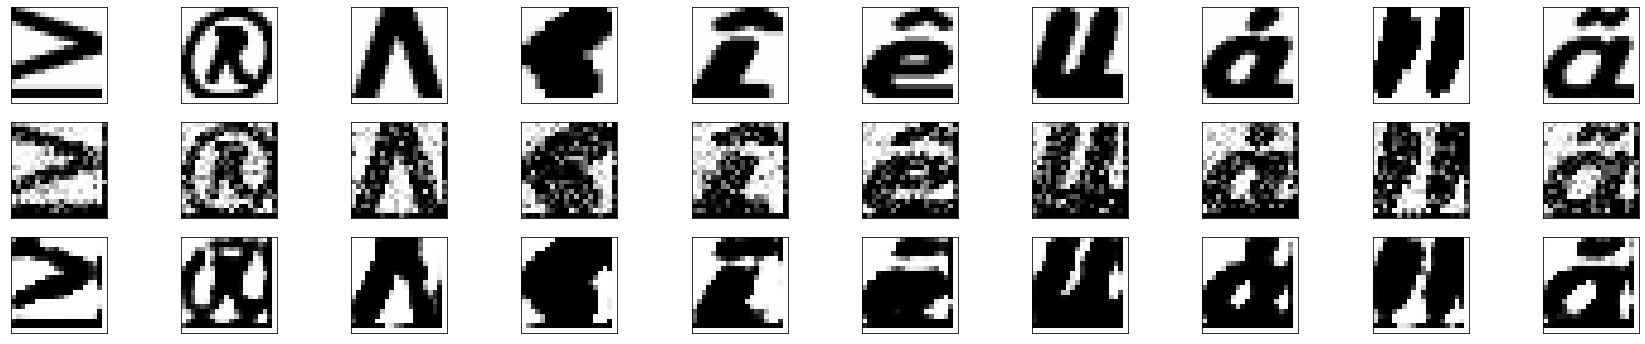

In [112]:
# encode and decode some digits
# note that we take them from the *test* set
denoised_images = denoiser.predict(x_test_noisy)

n = 10  # how many digits we will display
plt.figure(figsize=(30, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(expandLetter(X_test[i]).reshape(20, 20), cmap="Greys", interpolation=None)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # noisy version
    ax = plt.subplot(3, n, n+ i + 1)
    plt.imshow(x_test_noisy[i].reshape(20, 20), cmap="Greys", interpolation=None)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display denoised version
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(expandLetter(denoised_images[i]).reshape(20, 20), cmap="Greys", interpolation=None)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()